In [49]:
import pandas as pd
from model.featurisation import smiles2graph 
from model.CL_model_vas_info import GNNModelWithNewLoss
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torch_geometric.data import DataLoader as GeoDataLoader
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('data/freesolv.csv')
df.head()

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21


In [51]:
smiles_list = df["smiles"].tolist()
y = df['freesolv'].tolist()
data_list = smiles2graph(
    smiles_list,
    y
)
data_list[0]

Data(x=[13, 79], edge_index=[2, 26], edge_attr=[26, 10], global_features=[5], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [52]:
class AttentionFusion(nn.Module):
    def __init__(self, emb_dim, num_inputs=3, num_layers=2):
        super().__init__()
        self.emb_dim = emb_dim
        self.query = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.key_linears = nn.ModuleList([nn.Linear(emb_dim, emb_dim) for _ in range(num_layers)])
        self.value_linears = nn.ModuleList([nn.Linear(emb_dim, emb_dim) for _ in range(num_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(emb_dim) for _ in range(num_layers)])

    def forward(self, inputs):  # inputs: [B, 3, D]
        x = inputs
        q = self.query.expand(x.size(0), -1, -1)
        for i in range(len(self.key_linears)):
            k = self.key_linears[i](x)
            v = self.value_linears[i](x)
            scores = torch.matmul(q, k.transpose(-2, -1)) / self.emb_dim**0.5
            weights = torch.softmax(scores, dim=-1)
            context = torch.matmul(weights, v)
            q = self.norms[i](context + q)
        return q.squeeze(1)

In [89]:
class TransformerFusionModel(nn.Module):
    def __init__(self, emb_dim, hidden_dim=512):
        super().__init__()
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.query  = nn.Parameter(torch.randn(emb_dim))
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, N, D = x.size()
        K = self.k_proj(x)
        V = self.v_proj(x)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(B, 1, D)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        weights = torch.softmax(scores, dim=-1)
        fused = torch.matmul(weights, V).squeeze(1)
        out = self.mlp(fused).squeeze(-1)
        return out, weights.squeeze(1)

class WeightedFusion(nn.Module):
    def __init__(self, num_inputs=3, emb_dim=512, dropout=0.1, layer_norm_out=True):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_inputs = num_inputs
        self.linear = nn.Sequential(
            nn.Linear(emb_dim, emb_dim), nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )
        self.weight_logits = nn.Parameter(torch.zeros(num_inputs))  # initialized to uniform weights
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(emb_dim) if layer_norm_out else None
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, embs):  # embs: [B, N, D]
        B, N, D = embs.size()
        x = self.linear(embs)  # shape [B, N, D]
        norm_weights = torch.softmax(self.weight_logits, dim=0)  # shape [N]
        fused = torch.einsum('bnd,n->bd', x, norm_weights)  # [B, D]
        fused = self.dropout(fused)
        if self.layer_norm is not None:
            fused = self.layer_norm(fused)
        out = self.mlp(fused).squeeze(-1)
        return out, norm_weights
        
class MLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.mlp(x).squeeze(-1)
        return out


# fine-tune model
class FusionFineTuneModel(nn.Module):
    def __init__(self, encoder_list, fusion_model, fusion_method='attention'):
        super().__init__()
        self.encoders = nn.ModuleList(encoder_list)
        self.fusion = fusion_model
        self.fusion_method = fusion_method

    def forward(self, data):
        embs = [encoder(data) for encoder in self.encoders]  # list of [B, D]
        embs = torch.stack(embs, dim=1)  # [B, 3, D]
        if self.fusion_method == 'attention':
            out, weights = self.fusion(embs)
            return out, weights
        else:
            out = self.fusion(torch.cat([embs[:, i, :] for i in range(embs.size(1))], dim=1))
            return out


In [54]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        label = batch.y.float().view(-1).to(device)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            label = batch.y.view(-1).float()
            preds.append(pred.cpu())
            labels.append(label.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    rmse = mean_squared_error(labels, preds) ** 0.5
    r2 = r2_score(labels, preds)
    return rmse, r2

In [55]:
divice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_list = []
for i in range(3):
    model_path = os.path.join('models', str(i), "best_model.pth")

    
    model = GNNModelWithNewLoss(
        num_node_features=data_list[0].x.shape[1],
        num_edge_features=data_list[0].edge_attr.shape[1],
        num_global_features=data_list[0].global_features.shape[0],
        hidden_dim=512
    )

    state_dict = torch.load(model_path, map_location=torch.device(divice))
    model.load_state_dict(state_dict['encoder_state_dict'])
    model_list.append(model)

C:\Users\27476\AppData\Local\Temp\ipykernel_34728\3963176572.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devi

In [59]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_list, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_loader = GeoDataLoader(train_data, batch_size=32, shuffle=True)
val_loader = GeoDataLoader(val_data, batch_size=64)
test_loader = GeoDataLoader(test_data, batch_size=64)

[Epoch 00] Train Loss=5.0872, Val RMSE=5.2022
[Epoch 01] Train Loss=5.0025, Val RMSE=5.1177
[Epoch 02] Train Loss=4.9527, Val RMSE=4.9852
[Epoch 03] Train Loss=4.7020, Val RMSE=4.7662
[Epoch 04] Train Loss=4.4018, Val RMSE=4.4030
[Epoch 05] Train Loss=3.9863, Val RMSE=3.8720
[Epoch 06] Train Loss=3.3868, Val RMSE=3.2588
[Epoch 07] Train Loss=2.8518, Val RMSE=2.7155
[Epoch 08] Train Loss=2.4126, Val RMSE=2.2077
[Epoch 09] Train Loss=2.1834, Val RMSE=1.8410
[Epoch 10] Train Loss=1.8844, Val RMSE=1.5620
[Epoch 11] Train Loss=1.7342, Val RMSE=1.4332
[Epoch 12] Train Loss=1.5538, Val RMSE=1.3583
[Epoch 13] Train Loss=1.5032, Val RMSE=1.3524
[Epoch 14] Train Loss=1.3722, Val RMSE=1.3683
[Epoch 15] Train Loss=1.3308, Val RMSE=1.3567
[Epoch 16] Train Loss=1.3618, Val RMSE=1.3465
[Epoch 17] Train Loss=1.2714, Val RMSE=1.3410
[Epoch 18] Train Loss=1.2830, Val RMSE=1.2991
[Epoch 19] Train Loss=1.2138, Val RMSE=1.3046
[Epoch 20] Train Loss=1.3306, Val RMSE=1.2696
[Epoch 21] Train Loss=1.1704, Val 

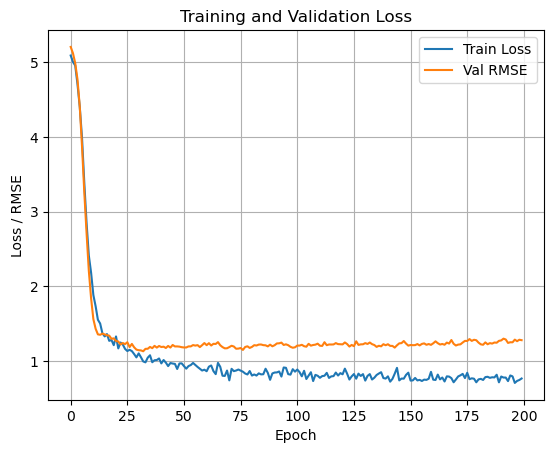

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion = MLP(emb_dim=512*3)
model = FusionFineTuneModel(model_list, fusion,fusion_method='mlp').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.MSELoss()

train_losses, val_rmses = [], []
best_val_rmse = float('inf')
best_model_state = None
for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        label = batch.y.view(-1).float().to(device)
        loss = criterion(pred, label)**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            label = batch.y.view(-1).float()
            preds.append(pred.cpu())
            labels.append(label.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    rmse = criterion(pred, label) ** 0.5
    val_rmses.append(rmse.item())
    if rmse < best_val_rmse:
        best_val_rmse = rmse
        best_model_state = model.state_dict()
    print(f"[Epoch {epoch:02d}] Train Loss={avg_loss:.4f}, Val RMSE={rmse:.4f}")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / RMSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


✅ Final Test: Loss=1.4965, RMSE=1.2233


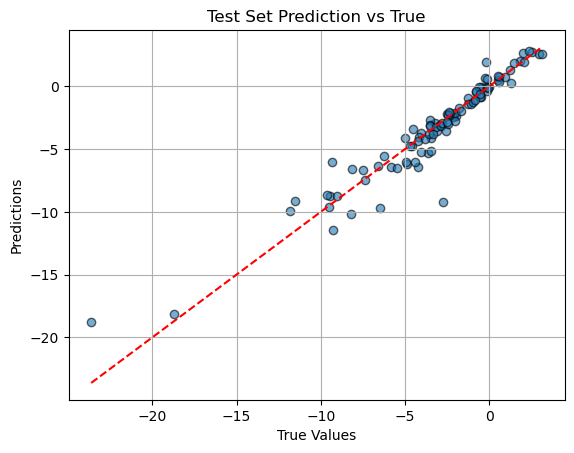

In [65]:
model.load_state_dict(best_model_state)
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch)
        label = batch.y.view(-1).float()
        preds.append(pred.cpu())
        labels.append(label.cpu())
preds = torch.cat(preds)
labels = torch.cat(labels)
test_loss = criterion(preds, labels).item()
test_rmse = criterion(labels, preds) ** 0.5
print(f"\n✅ Final Test: Loss={test_loss:.4f}, RMSE={test_rmse:.4f}")

# === 10. Test plot ===
plt.figure()
plt.scatter(labels, preds, alpha=0.6, edgecolors='k')
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set Prediction vs True')
plt.grid(True)
plt.show()

[Epoch 00] Train Loss=5.1335, Val RMSE=5.3065
[Epoch 01] Train Loss=5.1567, Val RMSE=5.2201
[Epoch 02] Train Loss=5.0023, Val RMSE=5.0745
[Epoch 03] Train Loss=4.8135, Val RMSE=4.7969
[Epoch 04] Train Loss=4.4153, Val RMSE=4.2527
[Epoch 05] Train Loss=3.7055, Val RMSE=3.3661
[Epoch 06] Train Loss=2.9002, Val RMSE=2.7315
[Epoch 07] Train Loss=2.6878, Val RMSE=2.5810
[Epoch 08] Train Loss=2.6437, Val RMSE=2.4896
[Epoch 09] Train Loss=2.5309, Val RMSE=2.2259
[Epoch 10] Train Loss=2.3768, Val RMSE=2.0321
[Epoch 11] Train Loss=2.3013, Val RMSE=1.9359
[Epoch 12] Train Loss=2.3288, Val RMSE=1.9209
[Epoch 13] Train Loss=2.2140, Val RMSE=1.8740
[Epoch 14] Train Loss=2.1771, Val RMSE=1.9810
[Epoch 15] Train Loss=1.9848, Val RMSE=1.8227
[Epoch 16] Train Loss=1.9534, Val RMSE=1.9004
[Epoch 17] Train Loss=1.8835, Val RMSE=1.7676
[Epoch 18] Train Loss=1.7204, Val RMSE=1.7419
[Epoch 19] Train Loss=1.6584, Val RMSE=1.7968
[Epoch 20] Train Loss=1.7085, Val RMSE=1.7313
[Epoch 21] Train Loss=1.6262, Val 

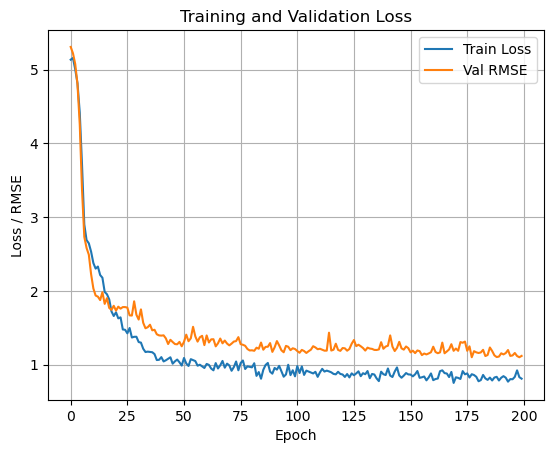

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion = TransformerFusionModel(emb_dim=512)
model = FusionFineTuneModel(model_list, fusion,fusion_method='attention').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.MSELoss()

train_losses, val_rmses = [], []
best_val_rmse = float('inf')
best_model_state = None
for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        pred,_= model(batch)
        label = batch.y.view(-1).float().to(device)
        loss = criterion(pred, label)**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred,_ = model(batch)
            label = batch.y.view(-1).float()
            preds.append(pred.cpu())
            labels.append(label.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    rmse = criterion(pred, label) ** 0.5
    val_rmses.append(rmse.item())
    if rmse < best_val_rmse:
        best_val_rmse = rmse
        best_model_state = model.state_dict()
    print(f"[Epoch {epoch:02d}] Train Loss={avg_loss:.4f}, Val RMSE={rmse:.4f}")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / RMSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


✅ Final Test: Loss=1.5062, RMSE=1.2273


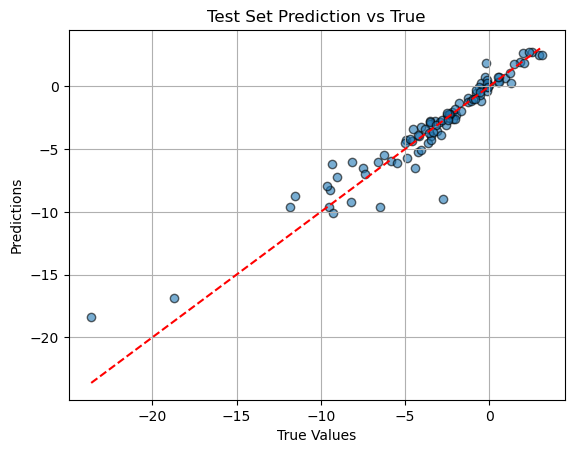

In [74]:
model.load_state_dict(best_model_state)
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred,_ = model(batch)
        label = batch.y.view(-1).float()
        preds.append(pred.cpu())
        labels.append(label.cpu())
preds = torch.cat(preds)
labels = torch.cat(labels)
test_loss = criterion(preds, labels).item()
test_rmse = criterion(labels, preds) ** 0.5
print(f"\n✅ Final Test: Loss={test_loss:.4f}, RMSE={test_rmse:.4f}")

# === 10. Test plot ===
plt.figure()
plt.scatter(labels, preds, alpha=0.6, edgecolors='k')
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set Prediction vs True')
plt.grid(True)
plt.show()

[Epoch 00] Train Loss=5.0841, Val RMSE=5.1329
[Epoch 01] Train Loss=4.9074, Val RMSE=5.0364
[Epoch 02] Train Loss=4.8531, Val RMSE=4.9297
[Epoch 03] Train Loss=4.7286, Val RMSE=4.7999
[Epoch 04] Train Loss=4.5177, Val RMSE=4.6529
[Epoch 05] Train Loss=4.4017, Val RMSE=4.4995
[Epoch 06] Train Loss=4.2380, Val RMSE=4.3424
[Epoch 07] Train Loss=4.0810, Val RMSE=4.1790
[Epoch 08] Train Loss=3.9087, Val RMSE=4.0142
[Epoch 09] Train Loss=3.7220, Val RMSE=3.8441
[Epoch 10] Train Loss=3.5944, Val RMSE=3.6520
[Epoch 11] Train Loss=3.3242, Val RMSE=3.4343
[Epoch 12] Train Loss=3.1161, Val RMSE=3.1630
[Epoch 13] Train Loss=2.8533, Val RMSE=2.8446
[Epoch 14] Train Loss=2.6821, Val RMSE=2.5398
[Epoch 15] Train Loss=2.3365, Val RMSE=2.2627
[Epoch 16] Train Loss=2.2692, Val RMSE=2.0526
[Epoch 17] Train Loss=2.0809, Val RMSE=1.8739
[Epoch 18] Train Loss=2.0087, Val RMSE=1.7360
[Epoch 19] Train Loss=1.8569, Val RMSE=1.6302
[Epoch 20] Train Loss=1.7731, Val RMSE=1.5702
[Epoch 21] Train Loss=1.7391, Val 

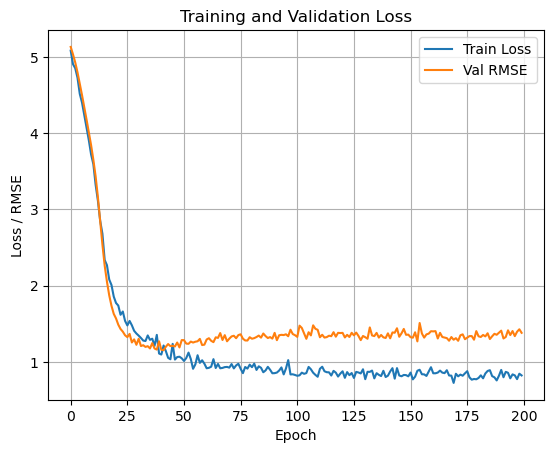

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion = WeightedFusion()
model = FusionFineTuneModel(model_list, fusion,fusion_method='attention').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

train_losses, val_rmses = [], []
best_val_rmse = float('inf')
best_model_state = None
for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        pred,_ = model(batch)
        label = batch.y.view(-1).float().to(device)
        loss = criterion(pred, label)**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred,_ = model(batch)
            label = batch.y.view(-1).float()
            preds.append(pred.cpu())
            labels.append(label.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    rmse = criterion(pred, label) ** 0.5
    val_rmses.append(rmse.item())
    if rmse < best_val_rmse:
        best_val_rmse = rmse
        best_model_state = model.state_dict()
    print(f"[Epoch {epoch:02d}] Train Loss={avg_loss:.4f}, Val RMSE={rmse:.4f}")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / RMSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


✅ Final Test: Loss=1.4117, RMSE=1.1882


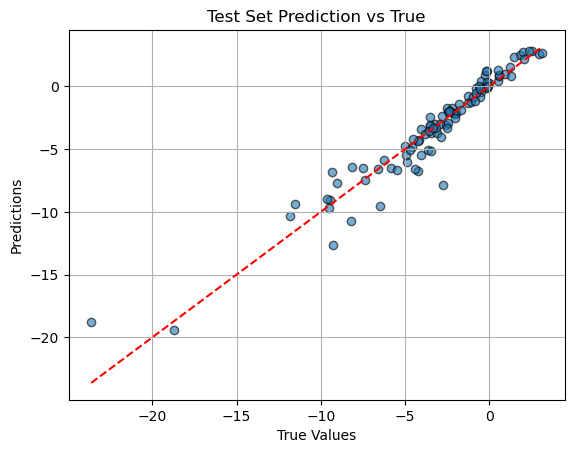

: 

In [ ]:
model.load_state_dict(best_model_state)
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred,_ = model(batch)
        label = batch.y.view(-1).float()
        preds.append(pred.cpu())
        labels.append(label.cpu())
preds = torch.cat(preds)
labels = torch.cat(labels)
test_loss = criterion(preds, labels).item()
test_rmse = criterion(labels, preds) ** 0.5
print(f"\n✅ Final Test: Loss={test_loss:.4f}, RMSE={test_rmse:.4f}")

# === 10. Test plot ===
plt.figure()
plt.scatter(labels, preds, alpha=0.6, edgecolors='k')
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set Prediction vs True')
plt.grid(True)
plt.show()